<a href="https://colab.research.google.com/github/across04/code_snippets/blob/main/hw3_p1_release.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1: Convolutional Neural Network

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Tue May  7 17:34:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Intro

We will be tackling a straightforward image classification task using the CIFAR-10 dataset. Our goal is to build a CNN model that can accurately classify the images into their respective categories.


# 0. Warm-up

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.Tensor``.

For vision, PyTorch has a package called ``torchvision``,
that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., ``torchvision.datasets``
and ``torch.utils.data.DataLoader``.
This provides a huge convenience and avoids writing boilerplate code.

In [ ]:
%matplotlib inline

# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from matplotlib import cm

## Recap on MNIST Dataset

The built-in datasets library in the package `torchvision` will automatically download some dataset if you set `download=True` when initializing the dataset.

In [ ]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True,
                                transform=transforms.ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True,
                               transform=transforms.ToTensor())
print("Print the training dataset:\n ", mnist_trainset)
print("Print the testing dataset:\n ", mnist_testset)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16818224.80it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 470088.49it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4425779.61it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4025043.05it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Print the training dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Print the testing dataset:
  Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


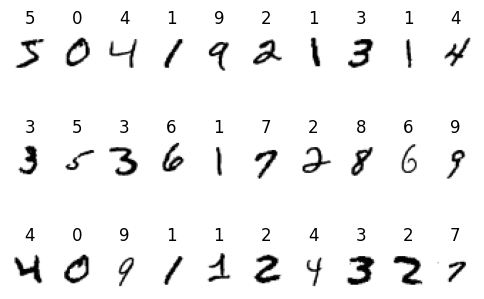

In [ ]:
fig, axs = plt.subplots(3, 10, figsize = (6, 4))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
  ax.imshow(mnist_trainset[i][0][0], cmap=cm.gray_r)
  ax.axis('off')
  ax.set_title('{}'.format(mnist_trainset[i][1]))

In [ ]:
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=1, shuffle=False)
print(train_loader)
print(test_loader)

for batch_id, (data, label) in enumerate(train_loader):
  print('batch_id:', batch_id)
  print(data.shape)
  print(label.shape)
  break

batch_id: 0
torch.Size([4, 1, 28, 28])
torch.Size([4])


## CIFAR-10 Dataset

Follow the above instructions on MNIST dataset, write code to load and visualize the CIFAR-10 dataset in the similar manner.

CIFAR-10 dataset has the classes (listed below): ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size $3 \times 32 \times 32$, i.e. 3-channel color images of $32 \times 32$ pixels in size.

<!-- <h4>Note:</h4>
The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].

1.   List item
2.   List item -->



In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True,
                                transform=transforms.ToTensor())
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True,
                               transform=transforms.ToTensor())
print("Print the training dataset:\n ", cifar_trainset)
print("Print the testing dataset:\n ", cifar_testset)

train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=1, shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 46950153.15it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Print the training dataset:
  Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Print the testing dataset:
  Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


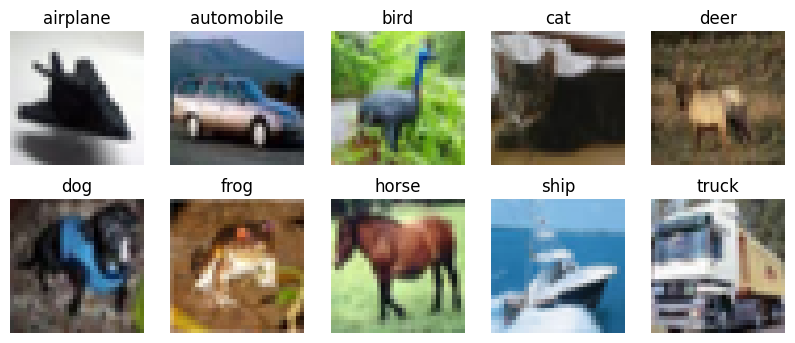

In [ ]:
# visualize the different classes of the cifar dataset

def cifar_imshow(img):
  npimg = img.numpy()
  return np.transpose(npimg, (1, 2, 0)) # reorganize the channel

# mapping from numeric label to class label
label_map = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

# for each class in the cifar dataset, load one image and display it in a 2 x 5 subplot
fig, axs = plt.subplots(2, 5, figsize = (10, 4))

for i in range(10):
  ax = axs[i // 5, i % 5]
  idx = next(idx for idx, label in enumerate(cifar_trainset.targets) if label == i)
  img, label = cifar_trainset[idx]
  ax.imshow(cifar_imshow(img))
  ax.axis('off')
  ax.set_title(label_map[label])

In [ ]:
# print out dimensions of a sample batch from the cifar10 dataset
for batch_id, (data, label) in enumerate(train_loader):
  print('batch_id:', batch_id)
  print(data.shape)
  print(label.shape)
  break

batch_id: 0
torch.Size([4, 3, 32, 32])
torch.Size([4])


# 1-a. Define Convolutional Neural Network

---





In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## CNN Model

Reading before implementation:
1. Official documentation: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html, make sure that you understand what are x,y,z in nn.Conv2d(x,y,z) representing individually.
2. Additional Animation on Convolution: https://towardsdatascience.com/conv2d-to-finally-understand-what-happens-in-the-forward-pass-1bbaafb0b148.

This is a very standard CNN pytorch model, the layers are already defined for you, in constrat with the `nn.Sequential()` method we taught in tutorial, we will be using another way to define our model:

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Read through official documentation: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        # and make sure you understand the concept of 2D convolution and Conv2d layer's definition
        # Here is also some cool animation: https://towardsdatascience.com/conv2d-to-finally-understand-what-happens-in-the-forward-pass-1bbaafb0b148
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # TODO: replace the xxx and yyy with proper numbers
        output_dim_after_conv = 400
        output_dim_after_fc = 10
        #

        self.fc1 = nn.Linear(output_dim_after_conv, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_dim_after_fc)

    def forward(self, x):
      # TODO: build your forward function
      # 1. First pass the x through the first conv layer followed by relu then pooling
      x = self.pool(F.relu(self.conv1(x)))
      # 2. Then pass the output of step 1 through the second conv layer followed by relu then pooling
      x = self.pool(F.relu(self.conv2(x)))
      # 3. Flatten the tensor
      x = torch.flatten(x, 1)
      # 4. Finally pass the output of step 3 into `fc1`, `fc2`, and `fc3` (remember the relu!)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = (self.fc3(x))



        # ENDS HERE
      return x

my_cnn = Net().to(device)  # operate on GPU

After finishing the TODO in `forward()` try to run the next code block.
```
Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=output_dim_after_conv, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=output_dim_after_fc, bias=True)
)
```
You should get the exact same output as above with `print(my_cnn)`, with the values you've defined for output_dim_after_conv and output_dim_after_fc.

In [ ]:
print(my_cnn)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Training Loop

Define your training loop, it should looks very similiar (almost the same) to what you did for MLP in hw2:

In [ ]:
def trainer(train_loader, valid_loader, model, config, device):

    # Define loss function (CrossEntropyLoss) and optimizer (SGD)
    criterion = nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.7)

    # Create directory for saving models if it doesn't exist
    if not os.path.isdir('./models'):
        os.mkdir('./models')

    # Extract configuration parameters
    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    # Initialize lists to store training and validation metrics
    train_loss_epoch_history = []
    train_acc_history = []
    valid_loss_history = []
    valid_acc_history = []
    train_loss_batch_history = []
    train_accuracy = []  # List to store training accuracy for each batch

    # Loop over epochs
    for epoch in range(n_epochs):
        model.train()  # Set the model to train mode
        loss_record = []  # List to store losses for each batch

        # tqdm is used to create a progress bar for training
        train_pbar = tqdm(train_loader, position=0, leave=True)

        # Loop over batches in the training data loader
        for x, y in train_pbar:
            optimizer.zero_grad()  # Reset gradients
            x, y = x.to(device), y.to(device)  # Move data to device (GPU)
            pred = model(x)  # Forward pass
            loss = criterion(pred, y)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            step += 1  # Increment step counter
            _, predicted = torch.max(pred.data, 1)  # Get predicted labels
            train_accuracy.append((predicted == y).sum().item() / predicted.size(0))  # Compute accuracy

            loss_record.append(loss.detach().item())  # Record loss for this batch

            # Update progress bar with current epoch number and loss
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

            train_loss_batch_history.append(loss.detach().item())  # Store loss for visualization

        # Calculate mean training loss for this epoch
        mean_train_loss = sum(loss_record) / len(loss_record)
        train_loss_epoch_history.append(mean_train_loss)  # Store epoch loss

        # Compute overall training accuracy for this epoch
        overall_train_accuracy = np.mean(train_accuracy)
        train_acc_history.append(overall_train_accuracy)  # Store training accuracy

        model.eval()  # Set the model to evaluation mode
        loss_record = []  # Reset loss record for validation

        val_accuracy = []  # List to store validation accuracy

        # Loop over batches in the validation data loader
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)  # Move data to device (GPU)
            with torch.no_grad():  # Disable gradient calculation
                pred = model(x)  # Forward pass
                loss = criterion(pred, y)  # Compute loss

                _, predicted = torch.max(pred.data, 1)  # Get predicted labels
                val_accuracy.append((predicted == y).sum().item() / predicted.size(0))  # Compute accuracy

            loss_record.append(loss.item())  # Record loss for this batch

        # Print training accuracy for this epoch
        print(f' training accuracy: {overall_train_accuracy}')

        # Calculate mean validation loss for this epoch
        mean_valid_loss = sum(loss_record) / len(loss_record)
        valid_loss_history.append(mean_valid_loss)  # Store epoch loss

        # Compute overall validation accuracy for this epoch
        overall_val_accuracy = np.mean(val_accuracy)
        valid_acc_history.append(overall_val_accuracy)  # Store validation accuracy

        print(f' validation accuracy: {overall_val_accuracy}')

    # Return all computed metrics
    return train_loss_epoch_history, train_acc_history, valid_loss_history, valid_acc_history

In [ ]:
config = { # do not modified
    'seed': 5201314,      # Your seed number, you can pick your lucky number. :)
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 250,      # Number of epochs.
    'batch_size': 256,
    'learning_rate': 0.01,
    'early_stop': 25,    # If model has not improved for this many consecutive epochs, stop training.
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}

In [ ]:
cifar_train_data, cifar_valid_data = random_split(cifar_trainset, [1-config['valid_ratio'], config['valid_ratio']])

train_loader = torch.utils.data.DataLoader(cifar_train_data, batch_size=config['batch_size'], shuffle=True)
valid_loader = torch.utils.data.DataLoader(cifar_valid_data, batch_size=config['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=config['batch_size'], shuffle=False)

In [ ]:
train_loss_epoch_history, train_acc_history, valid_loss_history, valid_acc_history = trainer(train_loader, valid_loader, my_cnn, config, device)

Epoch [1/250]: 100%|██████████| 157/157 [00:07<00:00, 21.01it/s, loss=1.03]


 training accuracy: 0.6097482085987261
 validation accuracy: 0.591015625


Epoch [2/250]: 100%|██████████| 157/157 [00:09<00:00, 16.37it/s, loss=1.03]


 training accuracy: 0.613094645700637
 validation accuracy: 0.6080078125


Epoch [3/250]: 100%|██████████| 157/157 [00:07<00:00, 21.50it/s, loss=0.971]


 training accuracy: 0.6147823779193206
 validation accuracy: 0.57958984375


Epoch [4/250]: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s, loss=1.13]


 training accuracy: 0.6174674064490446
 validation accuracy: 0.60185546875


Epoch [5/250]: 100%|██████████| 157/157 [00:08<00:00, 17.64it/s, loss=0.949]


 training accuracy: 0.620188097133758
 validation accuracy: 0.5986328125


Epoch [6/250]: 100%|██████████| 157/157 [00:06<00:00, 22.46it/s, loss=1.15]


 training accuracy: 0.6225119426751592
 validation accuracy: 0.582421875


Epoch [7/250]: 100%|██████████| 157/157 [00:07<00:00, 19.67it/s, loss=1.1]


 training accuracy: 0.6250035543676069
 validation accuracy: 0.592578125


Epoch [8/250]: 100%|██████████| 157/157 [00:08<00:00, 19.02it/s, loss=0.861]


 training accuracy: 0.6270277667197452
 validation accuracy: 0.60634765625


Epoch [9/250]: 100%|██████████| 157/157 [00:06<00:00, 22.49it/s, loss=0.672]


 training accuracy: 0.6292766940905874
 validation accuracy: 0.59638671875


Epoch [10/250]: 100%|██████████| 157/157 [00:08<00:00, 17.99it/s, loss=0.984]


 training accuracy: 0.6314042595541401
 validation accuracy: 0.59736328125


Epoch [11/250]: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s, loss=1.03]


 training accuracy: 0.6336742725825131
 validation accuracy: 0.61591796875


Epoch [12/250]: 100%|██████████| 157/157 [00:07<00:00, 22.11it/s, loss=0.771]


 training accuracy: 0.6357940220276008
 validation accuracy: 0.608984375


Epoch [13/250]: 100%|██████████| 157/157 [00:09<00:00, 17.34it/s, loss=1.05]


 training accuracy: 0.6378804813816756
 validation accuracy: 0.60478515625


Epoch [14/250]: 100%|██████████| 157/157 [00:07<00:00, 19.70it/s, loss=0.945]


 training accuracy: 0.640018980323021
 validation accuracy: 0.6048828125


Epoch [15/250]: 100%|██████████| 157/157 [00:07<00:00, 21.30it/s, loss=1.13]


 training accuracy: 0.6419801618895966
 validation accuracy: 0.60185546875


Epoch [16/250]: 100%|██████████| 157/157 [00:06<00:00, 22.45it/s, loss=0.99]


 training accuracy: 0.6439123457404459
 validation accuracy: 0.60517578125


Epoch [17/250]: 100%|██████████| 157/157 [00:07<00:00, 19.72it/s, loss=1.14]


 training accuracy: 0.6457913778568752
 validation accuracy: 0.58193359375


Epoch [18/250]: 100%|██████████| 157/157 [00:07<00:00, 21.03it/s, loss=0.995]


 training accuracy: 0.6477726357926398
 validation accuracy: 0.6146484375


Epoch [19/250]: 100%|██████████| 157/157 [00:07<00:00, 22.43it/s, loss=0.696]


 training accuracy: 0.6499355724103252
 validation accuracy: 0.61220703125


Epoch [20/250]: 100%|██████████| 157/157 [00:08<00:00, 19.57it/s, loss=1.02]


 training accuracy: 0.6518249900477707
 validation accuracy: 0.60732421875


Epoch [21/250]: 100%|██████████| 157/157 [00:07<00:00, 20.76it/s, loss=0.989]


 training accuracy: 0.6537098119502578
 validation accuracy: 0.587890625


Epoch [22/250]: 100%|██████████| 157/157 [00:07<00:00, 22.36it/s, loss=0.863]


 training accuracy: 0.6555273324406485
 validation accuracy: 0.60185546875


Epoch [23/250]: 100%|██████████| 157/157 [00:08<00:00, 19.31it/s, loss=0.861]


 training accuracy: 0.6574529216283578
 validation accuracy: 0.620703125


Epoch [24/250]: 100%|██████████| 157/157 [00:07<00:00, 19.77it/s, loss=0.833]


 training accuracy: 0.6593154939623143
 validation accuracy: 0.611328125


Epoch [25/250]: 100%|██████████| 157/157 [00:06<00:00, 22.49it/s, loss=0.746]


 training accuracy: 0.6612151671974522
 validation accuracy: 0.6234375


Epoch [26/250]: 100%|██████████| 157/157 [00:07<00:00, 20.14it/s, loss=0.678]


 training accuracy: 0.6629620131063204
 validation accuracy: 0.61552734375


Epoch [27/250]: 100%|██████████| 157/157 [00:08<00:00, 19.49it/s, loss=0.713]


 training accuracy: 0.6647084734017457
 validation accuracy: 0.6115234375


Epoch [28/250]: 100%|██████████| 157/157 [00:07<00:00, 22.07it/s, loss=0.794]


 training accuracy: 0.66646791827798
 validation accuracy: 0.59453125


Epoch [29/250]: 100%|██████████| 157/157 [00:07<00:00, 20.21it/s, loss=0.559]


 training accuracy: 0.6682295670437074
 validation accuracy: 0.62529296875


Epoch [30/250]: 100%|██████████| 157/157 [00:08<00:00, 17.54it/s, loss=0.568]


 training accuracy: 0.6700587181528662
 validation accuracy: 0.62060546875


Epoch [31/250]: 100%|██████████| 157/157 [00:07<00:00, 21.66it/s, loss=0.761]


 training accuracy: 0.6717209009656873
 validation accuracy: 0.62373046875


Epoch [32/250]: 100%|██████████| 157/157 [00:07<00:00, 21.50it/s, loss=0.944]


 training accuracy: 0.6733717219844745
 validation accuracy: 0.592578125


Epoch [33/250]: 100%|██████████| 157/157 [00:09<00:00, 16.66it/s, loss=0.844]


 training accuracy: 0.6749903493534066
 validation accuracy: 0.6197265625


Epoch [34/250]: 100%|██████████| 157/157 [00:09<00:00, 16.99it/s, loss=0.869]


 training accuracy: 0.6766440204664669
 validation accuracy: 0.61064453125


Epoch [35/250]: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s, loss=0.889]


 training accuracy: 0.6784057950409463
 validation accuracy: 0.61044921875


Epoch [36/250]: 100%|██████████| 157/157 [00:07<00:00, 20.22it/s, loss=0.874]


 training accuracy: 0.6799680975760792
 validation accuracy: 0.6205078125


Epoch [37/250]: 100%|██████████| 157/157 [00:08<00:00, 17.74it/s, loss=0.884]


 training accuracy: 0.6815790960148046
 validation accuracy: 0.598046875


Epoch [38/250]: 100%|██████████| 157/157 [00:08<00:00, 19.46it/s, loss=0.845]


 training accuracy: 0.6831760182701978
 validation accuracy: 0.6056640625


Epoch [39/250]: 100%|██████████| 157/157 [00:07<00:00, 22.17it/s, loss=0.697]


 training accuracy: 0.6848077943818389
 validation accuracy: 0.5484375


Epoch [40/250]: 100%|██████████| 157/157 [00:07<00:00, 20.00it/s, loss=0.947]


 training accuracy: 0.6863474074442675
 validation accuracy: 0.60966796875


Epoch [41/250]: 100%|██████████| 157/157 [00:08<00:00, 19.60it/s, loss=0.631]


 training accuracy: 0.687875635971726
 validation accuracy: 0.6056640625


Epoch [42/250]: 100%|██████████| 157/157 [00:07<00:00, 22.17it/s, loss=0.833]


 training accuracy: 0.6894554945784046
 validation accuracy: 0.60419921875


Epoch [43/250]: 100%|██████████| 157/157 [00:07<00:00, 20.24it/s, loss=0.755]


 training accuracy: 0.6910006387942527
 validation accuracy: 0.60498046875


Epoch [44/250]: 100%|██████████| 157/157 [00:08<00:00, 19.41it/s, loss=0.987]


 training accuracy: 0.6926118268674001
 validation accuracy: 0.5837890625


Epoch [45/250]: 100%|██████████| 157/157 [00:07<00:00, 22.06it/s, loss=0.622]


 training accuracy: 0.6941221027954706
 validation accuracy: 0.6037109375


Epoch [46/250]: 100%|██████████| 157/157 [00:07<00:00, 20.97it/s, loss=0.714]


 training accuracy: 0.6956554192052063
 validation accuracy: 0.6076171875


Epoch [47/250]: 100%|██████████| 157/157 [00:08<00:00, 19.23it/s, loss=0.801]


 training accuracy: 0.6972124229231603
 validation accuracy: 0.608984375


Epoch [48/250]: 100%|██████████| 157/157 [00:07<00:00, 21.45it/s, loss=0.7]


 training accuracy: 0.6987703813362527
 validation accuracy: 0.6220703125


Epoch [49/250]: 100%|██████████| 157/157 [00:07<00:00, 21.61it/s, loss=0.738]


 training accuracy: 0.7002693195112439
 validation accuracy: 0.61318359375


Epoch [50/250]: 100%|██████████| 157/157 [00:08<00:00, 19.20it/s, loss=0.672]


 training accuracy: 0.7018073248407644
 validation accuracy: 0.61826171875


Epoch [51/250]: 100%|██████████| 157/157 [00:07<00:00, 20.60it/s, loss=0.715]


 training accuracy: 0.7032425729049582
 validation accuracy: 0.62080078125


Epoch [52/250]: 100%|██████████| 157/157 [00:07<00:00, 22.18it/s, loss=0.599]


 training accuracy: 0.7046604184529642
 validation accuracy: 0.59765625


Epoch [53/250]: 100%|██████████| 157/157 [00:07<00:00, 19.86it/s, loss=0.653]


 training accuracy: 0.7061242826883788
 validation accuracy: 0.59970703125


Epoch [54/250]: 100%|██████████| 157/157 [00:07<00:00, 20.12it/s, loss=0.491]


 training accuracy: 0.7076477353149327
 validation accuracy: 0.617578125


Epoch [55/250]: 100%|██████████| 157/157 [00:07<00:00, 21.94it/s, loss=0.634]


 training accuracy: 0.7091528843370006
 validation accuracy: 0.615234375


Epoch [56/250]: 100%|██████████| 157/157 [00:08<00:00, 19.30it/s, loss=0.627]


 training accuracy: 0.7106020565570974
 validation accuracy: 0.604296875


Epoch [57/250]: 100%|██████████| 157/157 [00:08<00:00, 19.33it/s, loss=0.645]


 training accuracy: 0.7120278802100793
 validation accuracy: 0.6041015625


Epoch [58/250]: 100%|██████████| 157/157 [00:07<00:00, 22.09it/s, loss=0.709]


 training accuracy: 0.7134165488414232
 validation accuracy: 0.60224609375


Epoch [59/250]: 100%|██████████| 157/157 [00:08<00:00, 19.51it/s, loss=0.689]


 training accuracy: 0.714809170220231
 validation accuracy: 0.61240234375


Epoch [60/250]: 100%|██████████| 157/157 [00:08<00:00, 19.45it/s, loss=0.592]


 training accuracy: 0.7162312566348196
 validation accuracy: 0.6123046875


Epoch [61/250]: 100%|██████████| 157/157 [00:07<00:00, 22.04it/s, loss=0.647]


 training accuracy: 0.7176462814555706
 validation accuracy: 0.61005859375


Epoch [62/250]: 100%|██████████| 157/157 [00:08<00:00, 19.34it/s, loss=0.702]


 training accuracy: 0.7190309096979659
 validation accuracy: 0.598828125


Epoch [63/250]: 100%|██████████| 157/157 [00:08<00:00, 19.25it/s, loss=0.395]


 training accuracy: 0.7204276615104641
 validation accuracy: 0.5822265625


Epoch [64/250]: 100%|██████████| 157/157 [00:07<00:00, 22.19it/s, loss=0.474]


 training accuracy: 0.7218324697701035
 validation accuracy: 0.608984375


Epoch [65/250]: 100%|██████████| 157/157 [00:07<00:00, 20.06it/s, loss=0.463]


 training accuracy: 0.7232158715090642
 validation accuracy: 0.61513671875


Epoch [66/250]: 100%|██████████| 157/157 [00:08<00:00, 19.46it/s, loss=0.658]


 training accuracy: 0.7246086210432349
 validation accuracy: 0.59306640625


Epoch [67/250]: 100%|██████████| 157/157 [00:07<00:00, 21.86it/s, loss=0.438]


 training accuracy: 0.7259441991871851
 validation accuracy: 0.6111328125


Epoch [68/250]: 100%|██████████| 157/157 [00:07<00:00, 20.84it/s, loss=0.613]


 training accuracy: 0.7273202598117272
 validation accuracy: 0.604296875


Epoch [69/250]: 100%|██████████| 157/157 [00:08<00:00, 19.50it/s, loss=0.503]


 training accuracy: 0.728686363426567
 validation accuracy: 0.60654296875


Epoch [70/250]: 100%|██████████| 157/157 [00:07<00:00, 20.86it/s, loss=0.419]


 training accuracy: 0.7300159235668789
 validation accuracy: 0.59521484375


Epoch [71/250]: 100%|██████████| 157/157 [00:07<00:00, 21.91it/s, loss=0.462]


 training accuracy: 0.7313437752310039
 validation accuracy: 0.6029296875


Epoch [72/250]: 100%|██████████| 157/157 [00:08<00:00, 19.52it/s, loss=0.509]


 training accuracy: 0.7326347421266808
 validation accuracy: 0.59736328125


Epoch [73/250]: 100%|██████████| 157/157 [00:07<00:00, 20.43it/s, loss=0.453]


 training accuracy: 0.7339922481676991
 validation accuracy: 0.6009765625


Epoch [74/250]: 100%|██████████| 157/157 [00:07<00:00, 22.15it/s, loss=0.566]


 training accuracy: 0.7353339107419521
 validation accuracy: 0.5931640625


Epoch [75/250]: 100%|██████████| 157/157 [00:08<00:00, 19.30it/s, loss=0.613]


 training accuracy: 0.7366480891719746
 validation accuracy: 0.59150390625


Epoch [76/250]: 100%|██████████| 157/157 [00:08<00:00, 19.35it/s, loss=0.343]


 training accuracy: 0.7379535466602414
 validation accuracy: 0.603125


Epoch [77/250]: 100%|██████████| 157/157 [00:07<00:00, 21.98it/s, loss=0.414]


 training accuracy: 0.7392351130159649
 validation accuracy: 0.61298828125


Epoch [78/250]: 100%|██████████| 157/157 [00:08<00:00, 19.17it/s, loss=0.564]


 training accuracy: 0.7405396404948554
 validation accuracy: 0.5951171875


Epoch [79/250]: 100%|██████████| 157/157 [00:08<00:00, 19.36it/s, loss=0.459]


 training accuracy: 0.7418048430823188
 validation accuracy: 0.59990234375


Epoch [80/250]: 100%|██████████| 157/157 [00:07<00:00, 21.88it/s, loss=0.503]


 training accuracy: 0.7430598750995223
 validation accuracy: 0.59873046875


Epoch [81/250]: 100%|██████████| 157/157 [00:08<00:00, 19.59it/s, loss=0.542]


 training accuracy: 0.7442842258394275
 validation accuracy: 0.50283203125


Epoch [82/250]: 100%|██████████| 157/157 [00:08<00:00, 19.20it/s, loss=0.317]


 training accuracy: 0.7454896375446637
 validation accuracy: 0.6021484375


Epoch [83/250]: 100%|██████████| 157/157 [00:07<00:00, 21.90it/s, loss=0.427]


 training accuracy: 0.7467817128386156
 validation accuracy: 0.60400390625


Epoch [84/250]: 100%|██████████| 157/157 [00:07<00:00, 20.57it/s, loss=0.31]


 training accuracy: 0.7480335461214741
 validation accuracy: 0.59609375


Epoch [85/250]: 100%|██████████| 157/157 [00:08<00:00, 19.21it/s, loss=0.573]


 training accuracy: 0.7492688038591233
 validation accuracy: 0.598046875


Epoch [86/250]: 100%|██████████| 157/157 [00:07<00:00, 21.45it/s, loss=0.61]


 training accuracy: 0.7505135234594875
 validation accuracy: 0.56357421875


Epoch [87/250]: 100%|██████████| 157/157 [00:07<00:00, 21.40it/s, loss=0.558]


 training accuracy: 0.7517199053737462
 validation accuracy: 0.59091796875


Epoch [88/250]: 100%|██████████| 157/157 [00:08<00:00, 19.25it/s, loss=0.362]


 training accuracy: 0.7529180954147365
 validation accuracy: 0.5837890625


Epoch [89/250]: 100%|██████████| 157/157 [00:07<00:00, 20.91it/s, loss=0.441]


 training accuracy: 0.7541284978172189
 validation accuracy: 0.59423828125


Epoch [90/250]: 100%|██████████| 157/157 [00:07<00:00, 21.86it/s, loss=0.554]


 training accuracy: 0.7553750331740977
 validation accuracy: 0.60546875


Epoch [91/250]: 100%|██████████| 157/157 [00:08<00:00, 19.24it/s, loss=0.315]


 training accuracy: 0.7565747598341149
 validation accuracy: 0.588671875


Epoch [92/250]: 100%|██████████| 157/157 [00:07<00:00, 19.85it/s, loss=0.433]


 training accuracy: 0.757773556494046
 validation accuracy: 0.5740234375


Epoch [93/250]: 100%|██████████| 157/157 [00:07<00:00, 21.98it/s, loss=0.416]


 training accuracy: 0.7589543310389699
 validation accuracy: 0.59873046875


Epoch [94/250]: 100%|██████████| 157/157 [00:08<00:00, 19.27it/s, loss=0.446]


 training accuracy: 0.760177477893346
 validation accuracy: 0.57822265625


Epoch [95/250]: 100%|██████████| 157/157 [00:08<00:00, 19.08it/s, loss=0.401]


 training accuracy: 0.7613565412336574
 validation accuracy: 0.59208984375


Epoch [96/250]: 100%|██████████| 157/157 [00:07<00:00, 21.75it/s, loss=0.382]


 training accuracy: 0.7625341071191614
 validation accuracy: 0.59306640625


Epoch [97/250]: 100%|██████████| 157/157 [00:08<00:00, 19.46it/s, loss=0.315]


 training accuracy: 0.7636776462669906
 validation accuracy: 0.5857421875


Epoch [98/250]: 100%|██████████| 157/157 [00:08<00:00, 19.26it/s, loss=0.698]


 training accuracy: 0.7648577643637072
 validation accuracy: 0.5314453125


Epoch [99/250]: 100%|██████████| 157/157 [00:07<00:00, 21.94it/s, loss=0.165]


 training accuracy: 0.7659808675931288
 validation accuracy: 0.58212890625


Epoch [100/250]: 100%|██████████| 157/157 [00:07<00:00, 19.96it/s, loss=0.404]


 training accuracy: 0.7671145999203821
 validation accuracy: 0.591796875


Epoch [101/250]: 100%|██████████| 157/157 [00:08<00:00, 19.09it/s, loss=0.373]


 training accuracy: 0.768307667749259
 validation accuracy: 0.57001953125


Epoch [102/250]: 100%|██████████| 157/157 [00:07<00:00, 22.02it/s, loss=0.416]


 training accuracy: 0.7694544129355564
 validation accuracy: 0.5890625


Epoch [103/250]: 100%|██████████| 157/157 [00:07<00:00, 20.17it/s, loss=0.293]


 training accuracy: 0.7705675379537443
 validation accuracy: 0.57705078125


Epoch [104/250]: 100%|██████████| 157/157 [00:08<00:00, 19.21it/s, loss=0.412]


 training accuracy: 0.7716812664594561
 validation accuracy: 0.56376953125


Epoch [105/250]: 100%|██████████| 157/157 [00:07<00:00, 20.94it/s, loss=0.345]


 training accuracy: 0.7728017421140431
 validation accuracy: 0.58876953125


Epoch [106/250]: 100%|██████████| 157/157 [00:07<00:00, 21.82it/s, loss=0.332]


 training accuracy: 0.7739383975784161
 validation accuracy: 0.57900390625


Epoch [107/250]: 100%|██████████| 157/157 [00:08<00:00, 19.25it/s, loss=0.431]


 training accuracy: 0.7750872912822192
 validation accuracy: 0.58125


Epoch [108/250]: 100%|██████████| 157/157 [00:07<00:00, 19.84it/s, loss=0.494]


 training accuracy: 0.7761872640953055
 validation accuracy: 0.57431640625


Epoch [109/250]: 100%|██████████| 157/157 [00:07<00:00, 21.70it/s, loss=0.263]


 training accuracy: 0.7772519886197627
 validation accuracy: 0.575


Epoch [110/250]: 100%|██████████| 157/157 [00:08<00:00, 19.08it/s, loss=0.297]


 training accuracy: 0.7783292468876665
 validation accuracy: 0.581640625


Epoch [111/250]: 100%|██████████| 157/157 [00:08<00:00, 19.04it/s, loss=0.224]


 training accuracy: 0.7793794740201986
 validation accuracy: 0.60380859375


Epoch [112/250]: 100%|██████████| 157/157 [00:07<00:00, 21.64it/s, loss=0.255]


 training accuracy: 0.7804282746388762
 validation accuracy: 0.586328125


Epoch [113/250]: 100%|██████████| 157/157 [00:08<00:00, 19.54it/s, loss=0.388]


 training accuracy: 0.7815765300011274
 validation accuracy: 0.59033203125


Epoch [114/250]: 100%|██████████| 157/157 [00:08<00:00, 19.27it/s, loss=0.442]


 training accuracy: 0.7826387288384177
 validation accuracy: 0.58515625


Epoch [115/250]: 100%|██████████| 157/157 [00:07<00:00, 21.73it/s, loss=0.411]


 training accuracy: 0.7836735841872058
 validation accuracy: 0.576953125


Epoch [116/250]: 100%|██████████| 157/157 [00:07<00:00, 19.98it/s, loss=0.204]


 training accuracy: 0.7846541342933231
 validation accuracy: 0.58173828125


Epoch [117/250]: 100%|██████████| 157/157 [00:08<00:00, 19.19it/s, loss=0.418]


 training accuracy: 0.7856430160868855
 validation accuracy: 0.57431640625


Epoch [118/250]: 100%|██████████| 157/157 [00:07<00:00, 21.29it/s, loss=0.379]


 training accuracy: 0.7866490843949044
 validation accuracy: 0.58828125


Epoch [119/250]: 100%|██████████| 157/157 [00:07<00:00, 20.89it/s, loss=0.419]


 training accuracy: 0.7876409620376813
 validation accuracy: 0.53798828125


Epoch [120/250]: 100%|██████████| 157/157 [00:08<00:00, 19.26it/s, loss=0.111]


 training accuracy: 0.7886020020567941
 validation accuracy: 0.5857421875


Epoch [121/250]: 100%|██████████| 157/157 [00:07<00:00, 20.46it/s, loss=0.276]


 training accuracy: 0.7895609339632573
 validation accuracy: 0.5712890625


Epoch [122/250]: 100%|██████████| 157/157 [00:07<00:00, 21.70it/s, loss=0.396]


 training accuracy: 0.7905447295604051
 validation accuracy: 0.576953125


Epoch [123/250]: 100%|██████████| 157/157 [00:08<00:00, 19.16it/s, loss=0.208]


 training accuracy: 0.7915242607840091
 validation accuracy: 0.59619140625


Epoch [124/250]: 100%|██████████| 157/157 [00:07<00:00, 19.79it/s, loss=0.215]


 training accuracy: 0.7925413659595233
 validation accuracy: 0.59287109375


Epoch [125/250]: 100%|██████████| 157/157 [00:07<00:00, 21.79it/s, loss=0.185]


 training accuracy: 0.7935551353503185
 validation accuracy: 0.57529296875


Epoch [126/250]: 100%|██████████| 157/157 [00:08<00:00, 19.01it/s, loss=0.368]


 training accuracy: 0.7945387931579213
 validation accuracy: 0.5732421875


Epoch [127/250]: 100%|██████████| 157/157 [00:08<00:00, 19.18it/s, loss=0.257]


 training accuracy: 0.7954509300240734
 validation accuracy: 0.57607421875


Epoch [128/250]: 100%|██████████| 157/157 [00:07<00:00, 21.76it/s, loss=0.199]


 training accuracy: 0.7964213182971736
 validation accuracy: 0.58447265625


Epoch [129/250]: 100%|██████████| 157/157 [00:08<00:00, 19.24it/s, loss=0.34]


 training accuracy: 0.7973533241988842
 validation accuracy: 0.56416015625


Epoch [130/250]: 100%|██████████| 157/157 [00:08<00:00, 18.95it/s, loss=0.238]


 training accuracy: 0.7983326188143067
 validation accuracy: 0.57939453125


Epoch [131/250]: 100%|██████████| 157/157 [00:07<00:00, 21.60it/s, loss=0.183]


 training accuracy: 0.7993201335877863
 validation accuracy: 0.584375


Epoch [132/250]: 100%|██████████| 157/157 [00:07<00:00, 20.14it/s, loss=0.28]


 training accuracy: 0.8002646011267129
 validation accuracy: 0.5810546875


Epoch [133/250]: 100%|██████████| 157/157 [00:08<00:00, 19.10it/s, loss=0.198]


 training accuracy: 0.8012105801925196
 validation accuracy: 0.58740234375


Epoch [134/250]: 100%|██████████| 157/157 [00:07<00:00, 20.87it/s, loss=0.133]


 training accuracy: 0.8021972145641221
 validation accuracy: 0.57724609375


Epoch [135/250]: 100%|██████████| 157/157 [00:07<00:00, 21.10it/s, loss=0.19]


 training accuracy: 0.8031327406227884
 validation accuracy: 0.58193359375


Epoch [136/250]: 100%|██████████| 157/157 [00:08<00:00, 19.08it/s, loss=0.21]


 training accuracy: 0.8039441928742038
 validation accuracy: 0.58447265625


Epoch [137/250]: 100%|██████████| 157/157 [00:07<00:00, 20.23it/s, loss=0.234]


 training accuracy: 0.8048700180738295
 validation accuracy: 0.57626953125


Epoch [138/250]: 100%|██████████| 157/157 [00:07<00:00, 21.70it/s, loss=0.09]


 training accuracy: 0.8057616917058986
 validation accuracy: 0.58203125


Epoch [139/250]: 100%|██████████| 157/157 [00:08<00:00, 19.09it/s, loss=0.238]


 training accuracy: 0.8066725759519773
 validation accuracy: 0.56044921875


Epoch [140/250]: 100%|██████████| 157/157 [00:08<00:00, 19.28it/s, loss=0.154]


 training accuracy: 0.8075251293789809
 validation accuracy: 0.57705078125


Epoch [141/250]: 100%|██████████| 157/157 [00:07<00:00, 21.23it/s, loss=0.149]


 training accuracy: 0.808421879940823
 validation accuracy: 0.57490234375


Epoch [142/250]: 100%|██████████| 157/157 [00:08<00:00, 18.99it/s, loss=0.0928]


 training accuracy: 0.8093166883466404
 validation accuracy: 0.57509765625


Epoch [143/250]: 100%|██████████| 157/157 [00:08<00:00, 19.03it/s, loss=0.138]


 training accuracy: 0.8102569206271436
 validation accuracy: 0.58759765625


Epoch [144/250]: 100%|██████████| 157/157 [00:07<00:00, 21.48it/s, loss=0.116]


 training accuracy: 0.8112070740998761
 validation accuracy: 0.59541015625


Epoch [145/250]: 100%|██████████| 157/157 [00:07<00:00, 19.77it/s, loss=0.157]


 training accuracy: 0.8120830359103888
 validation accuracy: 0.5791015625


Epoch [146/250]: 100%|██████████| 157/157 [00:08<00:00, 18.92it/s, loss=0.233]


 training accuracy: 0.8129575639669313
 validation accuracy: 0.58603515625


Epoch [147/250]: 100%|██████████| 157/157 [00:07<00:00, 20.79it/s, loss=0.293]


 training accuracy: 0.813791589486113
 validation accuracy: 0.5416015625


Epoch [148/250]: 100%|██████████| 157/157 [00:07<00:00, 20.64it/s, loss=0.409]


 training accuracy: 0.814584924793424
 validation accuracy: 0.57578125


Epoch [149/250]: 100%|██████████| 157/157 [00:08<00:00, 19.08it/s, loss=0.345]


 training accuracy: 0.8153343815457615
 validation accuracy: 0.564453125


Epoch [150/250]: 100%|██████████| 157/157 [00:07<00:00, 20.11it/s, loss=0.304]


 training accuracy: 0.8160882762738854
 validation accuracy: 0.57138671875


Epoch [151/250]: 100%|██████████| 157/157 [00:07<00:00, 21.54it/s, loss=0.11]


 training accuracy: 0.8168499810182647
 validation accuracy: 0.56572265625


Epoch [152/250]: 100%|██████████| 157/157 [00:08<00:00, 18.82it/s, loss=0.249]


 training accuracy: 0.8176352193680858
 validation accuracy: 0.57744140625


Epoch [153/250]: 100%|██████████| 157/157 [00:08<00:00, 18.88it/s, loss=0.281]


 training accuracy: 0.8183856378273178
 validation accuracy: 0.57451171875


Epoch [154/250]: 100%|██████████| 157/157 [00:07<00:00, 21.41it/s, loss=0.126]


 training accuracy: 0.8191865732794276
 validation accuracy: 0.58388671875


Epoch [155/250]: 100%|██████████| 157/157 [00:08<00:00, 19.16it/s, loss=0.14]


 training accuracy: 0.8200492474830491
 validation accuracy: 0.57080078125


Epoch [156/250]: 100%|██████████| 157/157 [00:08<00:00, 18.65it/s, loss=0.347]


 training accuracy: 0.8208043697942186
 validation accuracy: 0.55400390625


Epoch [157/250]: 100%|██████████| 157/157 [00:07<00:00, 21.14it/s, loss=0.236]


 training accuracy: 0.8214874335672847
 validation accuracy: 0.56875


Epoch [158/250]: 100%|██████████| 157/157 [00:07<00:00, 20.07it/s, loss=0.157]


 training accuracy: 0.8223004263081513
 validation accuracy: 0.58642578125


Epoch [159/250]: 100%|██████████| 157/157 [00:08<00:00, 18.98it/s, loss=0.139]


 training accuracy: 0.8229803546749189
 validation accuracy: 0.5783203125


Epoch [160/250]: 100%|██████████| 157/157 [00:07<00:00, 20.68it/s, loss=0.188]


 training accuracy: 0.8237788303642516
 validation accuracy: 0.5873046875


Epoch [161/250]: 100%|██████████| 157/157 [00:07<00:00, 21.13it/s, loss=0.201]


 training accuracy: 0.8245630600447047
 validation accuracy: 0.564453125


Epoch [162/250]: 100%|██████████| 157/157 [00:08<00:00, 18.77it/s, loss=0.175]


 training accuracy: 0.8252199626975701
 validation accuracy: 0.5912109375


Epoch [163/250]: 100%|██████████| 157/157 [00:08<00:00, 19.04it/s, loss=0.0921]


 training accuracy: 0.8260118303309757
 validation accuracy: 0.58212890625


Epoch [164/250]: 100%|██████████| 157/157 [00:07<00:00, 21.42it/s, loss=0.0571]


 training accuracy: 0.8268544219453938
 validation accuracy: 0.58427734375


Epoch [165/250]: 100%|██████████| 157/157 [00:08<00:00, 18.71it/s, loss=0.147]


 training accuracy: 0.8277315853599692
 validation accuracy: 0.57978515625


Epoch [166/250]: 100%|██████████| 157/157 [00:08<00:00, 18.87it/s, loss=0.184]


 training accuracy: 0.8284637355153096
 validation accuracy: 0.5755859375


Epoch [167/250]: 100%|██████████| 157/157 [00:07<00:00, 20.61it/s, loss=0.0954]


 training accuracy: 0.829158661180823
 validation accuracy: 0.57763671875


Epoch [168/250]: 100%|██████████| 157/157 [00:08<00:00, 19.29it/s, loss=0.0768]


 training accuracy: 0.8299488348782984
 validation accuracy: 0.57744140625


Epoch [169/250]: 100%|██████████| 157/157 [00:08<00:00, 18.74it/s, loss=0.18]


 training accuracy: 0.8307021268326236
 validation accuracy: 0.57783203125


Epoch [170/250]: 100%|██████████| 157/157 [00:07<00:00, 20.75it/s, loss=0.119]


 training accuracy: 0.8313708903147247
 validation accuracy: 0.58134765625


Epoch [171/250]: 100%|██████████| 157/157 [00:07<00:00, 20.79it/s, loss=0.147]


 training accuracy: 0.8320884316683428
 validation accuracy: 0.58662109375


Epoch [172/250]: 100%|██████████| 157/157 [00:08<00:00, 18.83it/s, loss=0.192]


 training accuracy: 0.8328372648496519
 validation accuracy: 0.58291015625


Epoch [173/250]: 100%|██████████| 157/157 [00:07<00:00, 19.95it/s, loss=0.125]


 training accuracy: 0.8335860701005118
 validation accuracy: 0.57666015625


Epoch [174/250]: 100%|██████████| 157/157 [00:07<00:00, 20.16it/s, loss=0.11]


 training accuracy: 0.8342933802804012
 validation accuracy: 0.58369140625


Epoch [175/250]: 100%|██████████| 157/157 [00:08<00:00, 18.56it/s, loss=0.143]


 training accuracy: 0.8350362545495905
 validation accuracy: 0.57744140625


Epoch [176/250]: 100%|██████████| 157/157 [00:08<00:00, 18.50it/s, loss=0.0762]


 training accuracy: 0.8357559849088014
 validation accuracy: 0.58115234375


Epoch [177/250]: 100%|██████████| 157/157 [00:07<00:00, 20.88it/s, loss=0.102]


 training accuracy: 0.8365069418205046
 validation accuracy: 0.56025390625


Epoch [178/250]: 100%|██████████| 157/157 [00:08<00:00, 19.16it/s, loss=0.129]


 training accuracy: 0.8371421111250268
 validation accuracy: 0.57275390625


Epoch [179/250]: 100%|██████████| 157/157 [00:08<00:00, 18.77it/s, loss=0.0539]


 training accuracy: 0.8377700445681956
 validation accuracy: 0.58349609375


Epoch [180/250]: 100%|██████████| 157/157 [00:07<00:00, 20.08it/s, loss=0.207]


 training accuracy: 0.8383849190552017
 validation accuracy: 0.5833984375


Epoch [181/250]: 100%|██████████| 157/157 [00:07<00:00, 21.18it/s, loss=0.209]


 training accuracy: 0.8388250211141218
 validation accuracy: 0.5611328125


Epoch [182/250]: 100%|██████████| 157/157 [00:08<00:00, 18.70it/s, loss=0.187]


 training accuracy: 0.8393614496570309
 validation accuracy: 0.5732421875


Epoch [183/250]: 100%|██████████| 157/157 [00:08<00:00, 19.00it/s, loss=0.155]


 training accuracy: 0.8399266852441614
 validation accuracy: 0.58046875


Epoch [184/250]: 100%|██████████| 157/157 [00:07<00:00, 21.00it/s, loss=0.0404]


 training accuracy: 0.8405427047995707
 validation accuracy: 0.57890625


Epoch [185/250]: 100%|██████████| 157/157 [00:08<00:00, 18.68it/s, loss=0.0998]


 training accuracy: 0.8412774089774487
 validation accuracy: 0.568359375


Epoch [186/250]: 100%|██████████| 157/157 [00:08<00:00, 18.56it/s, loss=0.0983]


 training accuracy: 0.8420325716132456
 validation accuracy: 0.58603515625


Epoch [187/250]: 100%|██████████| 157/157 [00:07<00:00, 21.30it/s, loss=0.0783]


 training accuracy: 0.8427027540532716
 validation accuracy: 0.5794921875


Epoch [188/250]: 100%|██████████| 157/157 [00:08<00:00, 19.43it/s, loss=0.00806]


 training accuracy: 0.8434118624220761
 validation accuracy: 0.58046875


Epoch [189/250]: 100%|██████████| 157/157 [00:08<00:00, 18.68it/s, loss=0.0395]


 training accuracy: 0.8442000882536312
 validation accuracy: 0.5869140625


Epoch [190/250]: 100%|██████████| 157/157 [00:07<00:00, 20.59it/s, loss=0.0167]


 training accuracy: 0.8450107903117666
 validation accuracy: 0.586328125


Epoch [191/250]: 100%|██████████| 157/157 [00:07<00:00, 20.72it/s, loss=0.0122]


 training accuracy: 0.8458182139343715
 validation accuracy: 0.5921875


Epoch [192/250]: 100%|██████████| 157/157 [00:08<00:00, 18.63it/s, loss=0.00751]


 training accuracy: 0.8466195594479831
 validation accuracy: 0.59453125


Epoch [193/250]: 100%|██████████| 157/157 [00:08<00:00, 19.01it/s, loss=0.0076]


 training accuracy: 0.8474133743523317
 validation accuracy: 0.5857421875


Epoch [194/250]: 100%|██████████| 157/157 [00:07<00:00, 20.89it/s, loss=0.00855]


 training accuracy: 0.8481990055978725
 validation accuracy: 0.59326171875


Epoch [195/250]: 100%|██████████| 157/157 [00:08<00:00, 17.79it/s, loss=0.00505]


 training accuracy: 0.8489769618650989
 validation accuracy: 0.59755859375


Epoch [196/250]: 100%|██████████| 157/157 [00:08<00:00, 18.08it/s, loss=0.00555]


 training accuracy: 0.8497473606281685
 validation accuracy: 0.588671875


Epoch [197/250]: 100%|██████████| 157/157 [00:07<00:00, 21.02it/s, loss=0.00446]


 training accuracy: 0.8505099380839989
 validation accuracy: 0.59091796875


Epoch [198/250]: 100%|██████████| 157/157 [00:07<00:00, 19.81it/s, loss=0.00294]


 training accuracy: 0.8512649383967059
 validation accuracy: 0.58974609375


Epoch [199/250]: 100%|██████████| 157/157 [00:08<00:00, 18.32it/s, loss=0.00435]


 training accuracy: 0.8520123507665717
 validation accuracy: 0.58515625


Epoch [200/250]: 100%|██████████| 157/157 [00:08<00:00, 19.46it/s, loss=0.0105]


 training accuracy: 0.8527522890127388
 validation accuracy: 0.588671875


Epoch [201/250]: 100%|██████████| 157/157 [00:07<00:00, 20.91it/s, loss=0.00314]


 training accuracy: 0.8534848646892924
 validation accuracy: 0.588671875


Epoch [202/250]: 100%|██████████| 157/157 [00:08<00:00, 18.48it/s, loss=0.00552]


 training accuracy: 0.8542101871413256
 validation accuracy: 0.58974609375


Epoch [203/250]: 100%|██████████| 157/157 [00:08<00:00, 18.67it/s, loss=0.00553]


 training accuracy: 0.8549283635593486
 validation accuracy: 0.5908203125


Epoch [204/250]: 100%|██████████| 157/157 [00:07<00:00, 21.20it/s, loss=0.00371]


 training accuracy: 0.8556394990320969
 validation accuracy: 0.5943359375


Epoch [205/250]: 100%|██████████| 157/157 [00:08<00:00, 18.92it/s, loss=0.00676]


 training accuracy: 0.856343696597794
 validation accuracy: 0.59267578125


Epoch [206/250]: 100%|██████████| 157/157 [00:08<00:00, 18.60it/s, loss=0.00291]


 training accuracy: 0.8570410572939212
 validation accuracy: 0.59248046875


Epoch [207/250]: 100%|██████████| 157/157 [00:07<00:00, 20.81it/s, loss=0.00498]


 training accuracy: 0.8577316802055448
 validation accuracy: 0.59560546875


Epoch [208/250]: 100%|██████████| 157/157 [00:07<00:00, 19.99it/s, loss=0.00429]


 training accuracy: 0.8584156625122489
 validation accuracy: 0.589453125


Epoch [209/250]: 100%|██████████| 157/157 [00:08<00:00, 18.56it/s, loss=0.00421]


 training accuracy: 0.8590930995337214
 validation accuracy: 0.59228515625


Epoch [210/250]: 100%|██████████| 157/157 [00:08<00:00, 19.32it/s, loss=0.00456]


 training accuracy: 0.859764084774037
 validation accuracy: 0.5951171875


Epoch [211/250]: 100%|██████████| 157/157 [00:07<00:00, 20.93it/s, loss=0.00302]


 training accuracy: 0.8604287099646813
 validation accuracy: 0.59072265625


Epoch [212/250]: 100%|██████████| 157/157 [00:08<00:00, 18.43it/s, loss=0.00332]


 training accuracy: 0.8610870651063575
 validation accuracy: 0.59345703125


Epoch [213/250]: 100%|██████████| 157/157 [00:08<00:00, 18.61it/s, loss=0.00187]


 training accuracy: 0.861739238509614
 validation accuracy: 0.58701171875


Epoch [214/250]: 100%|██████████| 157/157 [00:07<00:00, 21.03it/s, loss=0.00604]


 training accuracy: 0.8623853168343354
 validation accuracy: 0.5880859375


Epoch [215/250]: 100%|██████████| 157/157 [00:08<00:00, 19.01it/s, loss=0.00196]


 training accuracy: 0.8630253851281292
 validation accuracy: 0.5896484375


Epoch [216/250]: 100%|██████████| 157/157 [00:08<00:00, 18.62it/s, loss=0.00207]


 training accuracy: 0.8636595268636471
 validation accuracy: 0.590234375


Epoch [217/250]: 100%|██████████| 157/157 [00:07<00:00, 20.43it/s, loss=0.0055]


 training accuracy: 0.8642878239748745
 validation accuracy: 0.588671875


Epoch [218/250]: 100%|██████████| 157/157 [00:07<00:00, 20.33it/s, loss=0.00182]


 training accuracy: 0.864910356892421
 validation accuracy: 0.5900390625


Epoch [219/250]: 100%|██████████| 157/157 [00:08<00:00, 18.60it/s, loss=0.000869]


 training accuracy: 0.8655272045778437
 validation accuracy: 0.5923828125


Epoch [220/250]: 100%|██████████| 157/157 [00:08<00:00, 19.33it/s, loss=0.00433]


 training accuracy: 0.8661384445570354
 validation accuracy: 0.596484375


Epoch [221/250]: 100%|██████████| 157/157 [00:07<00:00, 21.07it/s, loss=0.00167]


 training accuracy: 0.8667441529527048
 validation accuracy: 0.5849609375


Epoch [222/250]: 100%|██████████| 157/157 [00:08<00:00, 18.48it/s, loss=0.000987]


 training accuracy: 0.8673444045159809
 validation accuracy: 0.59345703125


Epoch [223/250]: 100%|██████████| 157/157 [00:08<00:00, 18.52it/s, loss=0.00226]


 training accuracy: 0.8679392726571649
 validation accuracy: 0.592578125


Epoch [224/250]: 100%|██████████| 157/157 [00:07<00:00, 20.79it/s, loss=0.0031]


 training accuracy: 0.8685288294756597
 validation accuracy: 0.5935546875


Epoch [225/250]: 100%|██████████| 157/157 [00:08<00:00, 19.48it/s, loss=0.00211]


 training accuracy: 0.8691131457891011
 validation accuracy: 0.58740234375


Epoch [226/250]: 100%|██████████| 157/157 [00:08<00:00, 18.52it/s, loss=0.00199]


 training accuracy: 0.8696922911617158
 validation accuracy: 0.59208984375


Epoch [227/250]: 100%|██████████| 157/157 [00:07<00:00, 20.20it/s, loss=0.00259]


 training accuracy: 0.8702663339319285
 validation accuracy: 0.59150390625


Epoch [228/250]: 100%|██████████| 157/157 [00:07<00:00, 20.67it/s, loss=0.00191]


 training accuracy: 0.8708353412392446
 validation accuracy: 0.58857421875


Epoch [229/250]: 100%|██████████| 157/157 [00:08<00:00, 18.40it/s, loss=0.00226]


 training accuracy: 0.871399379050427
 validation accuracy: 0.59521484375


Epoch [230/250]: 100%|██████████| 157/157 [00:08<00:00, 19.21it/s, loss=0.0014]


 training accuracy: 0.8719585121849903
 validation accuracy: 0.594921875


Epoch [231/250]: 100%|██████████| 157/157 [00:07<00:00, 20.82it/s, loss=0.00131]


 training accuracy: 0.8725128043400336
 validation accuracy: 0.58974609375


Epoch [232/250]: 100%|██████████| 157/157 [00:08<00:00, 18.52it/s, loss=0.0012]


 training accuracy: 0.87306231811443
 validation accuracy: 0.5845703125


Epoch [233/250]: 100%|██████████| 157/157 [00:08<00:00, 18.49it/s, loss=0.00243]


 training accuracy: 0.8736071150323939
 validation accuracy: 0.59248046875


Epoch [234/250]: 100%|██████████| 157/157 [00:07<00:00, 20.80it/s, loss=0.00154]


 training accuracy: 0.8741472555664435
 validation accuracy: 0.59033203125


Epoch [235/250]: 100%|██████████| 157/157 [00:08<00:00, 19.51it/s, loss=0.00229]


 training accuracy: 0.8746827991597778
 validation accuracy: 0.5900390625


Epoch [236/250]: 100%|██████████| 157/157 [00:08<00:00, 18.45it/s, loss=0.0023]


 training accuracy: 0.8752138042480838
 validation accuracy: 0.584375


Epoch [237/250]: 100%|██████████| 157/157 [00:07<00:00, 19.69it/s, loss=0.0014]


 training accuracy: 0.8757403282807923
 validation accuracy: 0.58779296875


Epoch [238/250]: 100%|██████████| 157/157 [00:07<00:00, 20.91it/s, loss=0.00234]


 training accuracy: 0.8762624277417973
 validation accuracy: 0.59189453125


Epoch [239/250]: 100%|██████████| 157/157 [00:08<00:00, 18.30it/s, loss=0.00103]


 training accuracy: 0.8767801581696559
 validation accuracy: 0.58935546875


Epoch [240/250]: 100%|██████████| 157/157 [00:08<00:00, 18.49it/s, loss=0.0025]


 training accuracy: 0.8772935741772824
 validation accuracy: 0.59462890625


Epoch [241/250]: 100%|██████████| 157/157 [00:07<00:00, 21.03it/s, loss=0.00136]


 training accuracy: 0.8778027294711526
 validation accuracy: 0.591796875


Epoch [242/250]: 100%|██████████| 157/157 [00:08<00:00, 18.50it/s, loss=0.000929]


 training accuracy: 0.8783076768700321
 validation accuracy: 0.5916015625


Epoch [243/250]: 100%|██████████| 157/157 [00:08<00:00, 18.32it/s, loss=0.00144]


 training accuracy: 0.8788084683232419
 validation accuracy: 0.58984375


Epoch [244/250]: 100%|██████████| 157/157 [00:07<00:00, 20.63it/s, loss=0.00194]


 training accuracy: 0.8793051549284745
 validation accuracy: 0.58505859375


Epoch [245/250]: 100%|██████████| 157/157 [00:07<00:00, 19.68it/s, loss=0.00192]


 training accuracy: 0.8797977869491745
 validation accuracy: 0.58583984375


Epoch [246/250]: 100%|██████████| 157/157 [00:08<00:00, 18.41it/s, loss=0.00104]


 training accuracy: 0.880286413831495
 validation accuracy: 0.58623046875


Epoch [247/250]: 100%|██████████| 157/157 [00:08<00:00, 19.49it/s, loss=0.00125]


 training accuracy: 0.8807710842208412
 validation accuracy: 0.58876953125


Epoch [248/250]: 100%|██████████| 157/157 [00:07<00:00, 20.98it/s, loss=0.00117]


 training accuracy: 0.8812518459780152
 validation accuracy: 0.5919921875


Epoch [249/250]: 100%|██████████| 157/157 [00:08<00:00, 18.26it/s, loss=0.00136]


 training accuracy: 0.881728746194971
 validation accuracy: 0.58671875


Epoch [250/250]: 100%|██████████| 157/157 [00:08<00:00, 18.34it/s, loss=0.00134]


 training accuracy: 0.8822018312101911
 validation accuracy: 0.5896484375


## Evaluation on CIFAR-10 Testing

Getting overall accuracy

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = my_cnn(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 58 %


Getting class-wise accuracies

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# Report percentage accuracy to 1 decimal place, e.g. 80.1%
# Iterate through test set batches
for images, labels in test_loader:
    # Move images and labels to GPU
    images, labels = images.to(device), labels.to(device)

    # Forward pass through the model
    outputs = my_cnn(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()

    # Update count of correct and total predictions for each class
    for i in range(len(labels)):
        label = labels[i]
        correct_pred[classes[label]] += c[i].item()
        total_pred[classes[label]] += 1

# Calculate and print accuracy separately for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * correct_count / total_pred[classname] if total_pred[classname] != 0 else 0
    print(f"Accuracy for class {classname}: {accuracy:.1f}%")

Accuracy for class plane: 63.7%
Accuracy for class car: 70.5%
Accuracy for class bird: 47.8%
Accuracy for class cat: 36.7%
Accuracy for class deer: 50.0%
Accuracy for class dog: 46.9%
Accuracy for class frog: 67.8%
Accuracy for class horse: 64.7%
Accuracy for class ship: 72.3%
Accuracy for class truck: 62.9%


# 1-b. Learning Curves

Plot two plots of the CNN model:
1. the learning curve (error versus epoch)
2. the accuracy curve (validation accuracy versus epoch)

Plot training metrics in blue and validation metrics in orange for both plots. Use the code template provided.

[1.1098117794200872, 1.090383340219024, 1.0804354992641765, 1.0621672063876109, 1.04713877864704, 1.039443751808944, 1.021533694996196, 1.0181730970455583, 1.0025929717501258, 0.9892295044698532, 0.9774542462294269, 0.9722817729992471, 0.9617399022837353, 0.943324615621263, 0.9401234004907547, 0.9308570930912237, 0.9186940029927879, 0.9073706284450118, 0.8949120891321997, 0.8876987019921564, 0.8790324406259379, 0.8707499652151849, 0.8545288284113453, 0.8473118088047975, 0.8415846687972925, 0.8317519141610261, 0.823625282497163, 0.816822813954323, 0.8086237444239817, 0.788861299775968, 0.7864634041573592, 0.7745874516523568, 0.7722149312875832, 0.7658509274197233, 0.7471326794593957, 0.7468001527391421, 0.7348002726864663, 0.7303198591159408, 0.7202414110967308, 0.7184376614108966, 0.7062226085905816, 0.6965990487936955, 0.6877165698701408, 0.6774821750297668, 0.6761038193277492, 0.6668244467419424, 0.6568828927483529, 0.6467993733989206, 0.6453353058380685, 0.6303693428161038, 0.632421

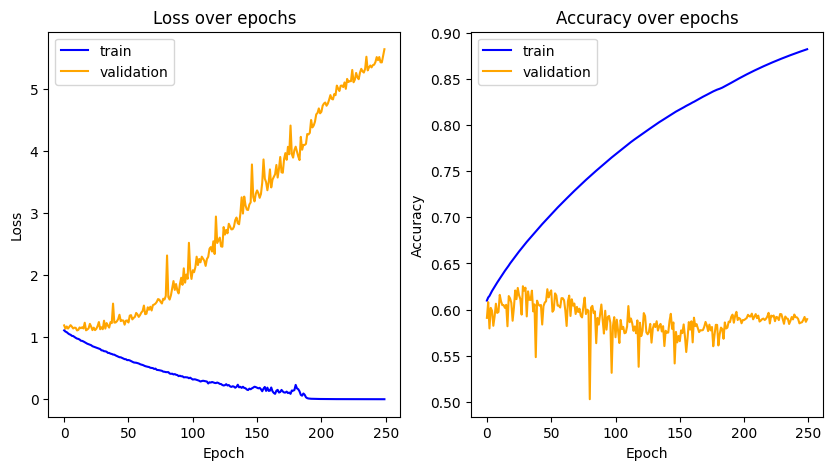

In [ ]:
# TODO 1-b

# extract training loss vector
train_loss = train_loss_epoch_history
print(train_loss_epoch_history)
# extract validation loss vector
valid_loss = valid_loss_history

# extract training acc vector
train_acc = train_acc_history

# extract validation acc vector
valid_acc = valid_acc_history

# create 1x2 subplots for loss on left, accuracy on right
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# plot train in blue, val in orange
axs[0].plot(train_loss, label='train', color='blue')
axs[0].plot(valid_loss, label='validation', color='orange')
axs[0].set_title('Loss over epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# plot train in blue, val in orange
axs[1].plot(train_acc, label='train', color='blue')
axs[1].plot(valid_acc, label='validation', color='orange')
axs[1].set_title('Accuracy over epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

# ENDS HERE

# 1-c. Try Different CNN Parameters
Try different CNN parameters/configurations/model architectures to see if you can reach 80\% accuracy on the CIFAR-10 testing set. Please briefly explain what you change and include the screenshot of model info (using `print(model)`) in the pdf.

In [ ]:
class your_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        # Read through official documentation: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.conv4 = nn.Conv2d(256,512, 3)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
      # TODO: build your forward function
      # 1. First pass the x through the first conv layer followed by relu then pooling
      x = self.pool(F.relu(self.conv1(x)))
      # 2. Then pass the output of step 1 through the second conv layer followed by relu then pooling
      x = self.pool(F.relu(self.conv2(x)))
      x = (F.relu(self.conv3(x)))
      x = (F.relu(self.conv4(x)))
      # 3. Flatten the tensor
      x = torch.flatten(x, 1)
      # 4. Finally pass the output of step 3 into `fc1`, `fc2`, and `fc3` (remember the relu!)
      x = F.relu(self.fc1(x))
      x = (self.fc2(x))
      return x
your_config = { # do not modified
    'seed': 5201314,      # Your seed number, you can pick your lucky number. :)
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 120,      # Number of epochs.
    'batch_size': 256,
    'learning_rate': 0.01,
    'early_stop': 25,    # If model has not improved for this many consecutive epochs, stop training.
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}
model = your_cnn().to(device)


In [ ]:
train_loss_epoch_history, train_acc_history, valid_loss_history, valid_acc_history = trainer(train_loader, valid_loader, model, your_config, device)

Epoch [1/120]: 100%|██████████| 157/157 [00:10<00:00, 14.57it/s, loss=2.3]


 training accuracy: 0.11303244426751592
 validation accuracy: 0.1263671875


Epoch [2/120]: 100%|██████████| 157/157 [00:11<00:00, 13.65it/s, loss=2.3]


 training accuracy: 0.13333499203821655
 validation accuracy: 0.140625


Epoch [3/120]: 100%|██████████| 157/157 [00:10<00:00, 14.52it/s, loss=2.28]


 training accuracy: 0.143494559447983
 validation accuracy: 0.16708984375


Epoch [4/120]: 100%|██████████| 157/157 [00:10<00:00, 14.49it/s, loss=2.06]


 training accuracy: 0.15476338574840764
 validation accuracy: 0.22333984375


Epoch [5/120]: 100%|██████████| 157/157 [00:10<00:00, 14.64it/s, loss=1.98]


 training accuracy: 0.16952129777070063
 validation accuracy: 0.22412109375


Epoch [6/120]: 100%|██████████| 157/157 [00:10<00:00, 14.99it/s, loss=1.83]


 training accuracy: 0.18361033704883228
 validation accuracy: 0.26728515625


Epoch [7/120]: 100%|██████████| 157/157 [00:10<00:00, 15.25it/s, loss=1.74]


 training accuracy: 0.19899837920837124
 validation accuracy: 0.31552734375


Epoch [8/120]: 100%|██████████| 157/157 [00:10<00:00, 15.51it/s, loss=1.8]


 training accuracy: 0.21443322054140126
 validation accuracy: 0.33125


Epoch [9/120]: 100%|██████████| 157/157 [00:10<00:00, 15.45it/s, loss=1.74]


 training accuracy: 0.229633868542109
 validation accuracy: 0.35419921875


Epoch [10/120]: 100%|██████████| 157/157 [00:10<00:00, 15.06it/s, loss=1.62]


 training accuracy: 0.2441655055732484
 validation accuracy: 0.3927734375


Epoch [11/120]: 100%|██████████| 157/157 [00:10<00:00, 14.82it/s, loss=1.51]


 training accuracy: 0.25830106398378694
 validation accuracy: 0.410546875


Epoch [12/120]: 100%|██████████| 157/157 [00:10<00:00, 14.62it/s, loss=1.62]


 training accuracy: 0.27202552746815284
 validation accuracy: 0.42763671875


Epoch [13/120]: 100%|██████████| 157/157 [00:10<00:00, 14.52it/s, loss=1.51]


 training accuracy: 0.2853859168299853
 validation accuracy: 0.4021484375


Epoch [14/120]: 100%|██████████| 157/157 [00:10<00:00, 14.51it/s, loss=1.45]


 training accuracy: 0.2977866952911738
 validation accuracy: 0.47265625


Epoch [15/120]: 100%|██████████| 157/157 [00:10<00:00, 14.49it/s, loss=1.48]


 training accuracy: 0.3096967887473461
 validation accuracy: 0.47822265625


Epoch [16/120]: 100%|██████████| 157/157 [00:10<00:00, 14.58it/s, loss=1.42]


 training accuracy: 0.32135281896894907
 validation accuracy: 0.48203125


Epoch [17/120]: 100%|██████████| 157/157 [00:10<00:00, 14.60it/s, loss=1.28]


 training accuracy: 0.33250983514424876
 validation accuracy: 0.48994140625


Epoch [18/120]: 100%|██████████| 157/157 [00:10<00:00, 14.42it/s, loss=1.54]


 training accuracy: 0.343121074398443
 validation accuracy: 0.52568359375


Epoch [19/120]: 100%|██████████| 157/157 [00:10<00:00, 14.57it/s, loss=1.13]


 training accuracy: 0.35333687772376804
 validation accuracy: 0.5318359375


Epoch [20/120]: 100%|██████████| 157/157 [00:10<00:00, 14.49it/s, loss=1.37]


 training accuracy: 0.36309588972929935
 validation accuracy: 0.53076171875


Epoch [21/120]: 100%|██████████| 157/157 [00:10<00:00, 15.59it/s, loss=1.44]


 training accuracy: 0.37222048453139217
 validation accuracy: 0.5400390625


Epoch [22/120]: 100%|██████████| 157/157 [00:10<00:00, 15.62it/s, loss=1.21]


 training accuracy: 0.3813388915026057
 validation accuracy: 0.547265625


Epoch [23/120]: 100%|██████████| 157/157 [00:10<00:00, 15.45it/s, loss=1.4]


 training accuracy: 0.3901306338271947
 validation accuracy: 0.50908203125


Epoch [24/120]: 100%|██████████| 157/157 [00:10<00:00, 14.91it/s, loss=0.886]


 training accuracy: 0.3986852690419321
 validation accuracy: 0.5830078125


Epoch [25/120]: 100%|██████████| 157/157 [00:10<00:00, 14.49it/s, loss=0.898]


 training accuracy: 0.4069924363057325
 validation accuracy: 0.5828125


Epoch [26/120]: 100%|██████████| 157/157 [00:10<00:00, 14.50it/s, loss=1]


 training accuracy: 0.41498690899069085
 validation accuracy: 0.58935546875


Epoch [27/120]: 100%|██████████| 157/157 [00:11<00:00, 14.26it/s, loss=0.959]


 training accuracy: 0.422892338995046
 validation accuracy: 0.59609375


Epoch [28/120]: 100%|██████████| 157/157 [00:10<00:00, 14.38it/s, loss=0.963]


 training accuracy: 0.4303370606801638
 validation accuracy: 0.60712890625


Epoch [29/120]: 100%|██████████| 157/157 [00:10<00:00, 14.51it/s, loss=0.931]


 training accuracy: 0.43769046507797055
 validation accuracy: 0.5861328125


Epoch [30/120]: 100%|██████████| 157/157 [00:11<00:00, 14.27it/s, loss=1.13]


 training accuracy: 0.4448248407643312
 validation accuracy: 0.6015625


Epoch [31/120]: 100%|██████████| 157/157 [00:10<00:00, 14.43it/s, loss=0.806]


 training accuracy: 0.45179589582905283
 validation accuracy: 0.61552734375


Epoch [32/120]: 100%|██████████| 157/157 [00:10<00:00, 14.29it/s, loss=1.2]


 training accuracy: 0.4585800656847134
 validation accuracy: 0.6306640625


Epoch [33/120]: 100%|██████████| 157/157 [00:11<00:00, 14.14it/s, loss=0.727]


 training accuracy: 0.46521846651225635
 validation accuracy: 0.6353515625


Epoch [34/120]: 100%|██████████| 157/157 [00:11<00:00, 14.12it/s, loss=0.9]


 training accuracy: 0.4717590857999251
 validation accuracy: 0.65986328125


Epoch [35/120]: 100%|██████████| 157/157 [00:11<00:00, 14.13it/s, loss=0.759]


 training accuracy: 0.4781783155141037
 validation accuracy: 0.65673828125


Epoch [36/120]: 100%|██████████| 157/157 [00:11<00:00, 13.93it/s, loss=0.811]


 training accuracy: 0.48444273044939845
 validation accuracy: 0.6341796875


Epoch [37/120]: 100%|██████████| 157/157 [00:10<00:00, 14.46it/s, loss=0.829]


 training accuracy: 0.4906011953434326
 validation accuracy: 0.65576171875


Epoch [38/120]: 100%|██████████| 157/157 [00:10<00:00, 14.60it/s, loss=0.821]


 training accuracy: 0.4965880877053302
 validation accuracy: 0.63720703125


Epoch [39/120]: 100%|██████████| 157/157 [00:10<00:00, 14.63it/s, loss=0.881]


 training accuracy: 0.5025167656785889
 validation accuracy: 0.68681640625


Epoch [40/120]: 100%|██████████| 157/157 [00:10<00:00, 14.79it/s, loss=0.796]


 training accuracy: 0.5082597283041401
 validation accuracy: 0.67470703125


Epoch [41/120]: 100%|██████████| 157/157 [00:10<00:00, 14.95it/s, loss=0.597]


 training accuracy: 0.5139634631816064
 validation accuracy: 0.678125


Epoch [42/120]: 100%|██████████| 157/157 [00:10<00:00, 14.74it/s, loss=0.588]


 training accuracy: 0.5195744948058841
 validation accuracy: 0.6958984375


Epoch [43/120]: 100%|██████████| 157/157 [00:10<00:00, 14.65it/s, loss=0.522]


 training accuracy: 0.5250015044067545
 validation accuracy: 0.6966796875


Epoch [44/120]: 100%|██████████| 157/157 [00:10<00:00, 14.48it/s, loss=0.669]


 training accuracy: 0.530421024536769
 validation accuracy: 0.69453125


Epoch [45/120]: 100%|██████████| 157/157 [00:10<00:00, 14.57it/s, loss=0.395]


 training accuracy: 0.5357384554140128
 validation accuracy: 0.69443359375


Epoch [46/120]: 100%|██████████| 157/157 [00:10<00:00, 14.47it/s, loss=0.676]


 training accuracy: 0.5409674864995846
 validation accuracy: 0.70830078125


Epoch [47/120]: 100%|██████████| 157/157 [00:11<00:00, 14.21it/s, loss=0.679]


 training accuracy: 0.5461333471676378
 validation accuracy: 0.71484375


Epoch [48/120]: 100%|██████████| 157/157 [00:11<00:00, 14.04it/s, loss=0.423]


 training accuracy: 0.5513073704551487
 validation accuracy: 0.69677734375


Epoch [49/120]: 100%|██████████| 157/157 [00:11<00:00, 13.97it/s, loss=0.786]


 training accuracy: 0.5563453586052255
 validation accuracy: 0.6908203125


Epoch [50/120]: 100%|██████████| 157/157 [00:11<00:00, 14.09it/s, loss=0.481]


 training accuracy: 0.5612783638535032
 validation accuracy: 0.70859375


Epoch [51/120]: 100%|██████████| 157/157 [00:11<00:00, 14.27it/s, loss=0.4]


 training accuracy: 0.5661959847633321
 validation accuracy: 0.70078125


Epoch [52/120]: 100%|██████████| 157/157 [00:10<00:00, 14.31it/s, loss=0.5]


 training accuracy: 0.571030208843704
 validation accuracy: 0.72158203125


Epoch [53/120]: 100%|██████████| 157/157 [00:11<00:00, 14.07it/s, loss=0.791]


 training accuracy: 0.5758815234046388
 validation accuracy: 0.71318359375


Epoch [54/120]: 100%|██████████| 157/157 [00:11<00:00, 14.20it/s, loss=0.446]


 training accuracy: 0.5806522211901392
 validation accuracy: 0.73173828125


Epoch [55/120]: 100%|██████████| 157/157 [00:10<00:00, 14.37it/s, loss=0.59]


 training accuracy: 0.5853448899826288
 validation accuracy: 0.7072265625


Epoch [56/120]: 100%|██████████| 157/157 [00:11<00:00, 14.26it/s, loss=0.478]


 training accuracy: 0.5900530133928571
 validation accuracy: 0.713671875


Epoch [57/120]: 100%|██████████| 157/157 [00:11<00:00, 14.15it/s, loss=0.367]


 training accuracy: 0.5947063743155659
 validation accuracy: 0.73349609375


Epoch [58/120]: 100%|██████████| 157/157 [00:11<00:00, 14.09it/s, loss=0.48]


 training accuracy: 0.5993897395947727
 validation accuracy: 0.66767578125


Epoch [59/120]: 100%|██████████| 157/157 [00:11<00:00, 13.88it/s, loss=0.434]


 training accuracy: 0.6039666381032063
 validation accuracy: 0.72236328125


Epoch [60/120]: 100%|██████████| 157/157 [00:10<00:00, 14.29it/s, loss=0.243]


 training accuracy: 0.608580895037155
 validation accuracy: 0.7220703125


Epoch [61/120]: 100%|██████████| 157/157 [00:10<00:00, 14.42it/s, loss=0.423]


 training accuracy: 0.6131274798997598
 validation accuracy: 0.72421875


Epoch [62/120]: 100%|██████████| 157/157 [00:10<00:00, 14.88it/s, loss=0.327]


 training accuracy: 0.6177043738442572
 validation accuracy: 0.72109375


Epoch [63/120]: 100%|██████████| 157/157 [00:10<00:00, 15.40it/s, loss=0.381]


 training accuracy: 0.6222244338287332
 validation accuracy: 0.70029296875


Epoch [64/120]: 100%|██████████| 157/157 [00:10<00:00, 15.45it/s, loss=0.205]


 training accuracy: 0.626708595616043
 validation accuracy: 0.723828125


Epoch [65/120]: 100%|██████████| 157/157 [00:10<00:00, 15.13it/s, loss=0.289]


 training accuracy: 0.631141291033807
 validation accuracy: 0.725


Epoch [66/120]: 100%|██████████| 157/157 [00:10<00:00, 14.67it/s, loss=0.187]


 training accuracy: 0.6355693429116
 validation accuracy: 0.72626953125


Epoch [67/120]: 100%|██████████| 157/157 [00:10<00:00, 14.33it/s, loss=0.183]


 training accuracy: 0.6399974153911969
 validation accuracy: 0.716796875


Epoch [68/120]: 100%|██████████| 157/157 [00:10<00:00, 14.42it/s, loss=0.237]


 training accuracy: 0.6443812347789434
 validation accuracy: 0.725390625


Epoch [69/120]: 100%|██████████| 157/157 [00:10<00:00, 14.49it/s, loss=0.25]


 training accuracy: 0.6487649139204283
 validation accuracy: 0.72041015625


Epoch [70/120]: 100%|██████████| 157/157 [00:10<00:00, 14.42it/s, loss=0.229]


 training accuracy: 0.6530446712920838
 validation accuracy: 0.72587890625


Epoch [71/120]: 100%|██████████| 157/157 [00:10<00:00, 14.43it/s, loss=0.145]


 training accuracy: 0.6573496512514578
 validation accuracy: 0.733984375


Epoch [72/120]: 100%|██████████| 157/157 [00:11<00:00, 14.04it/s, loss=0.224]


 training accuracy: 0.661601742193029
 validation accuracy: 0.70234375


Epoch [73/120]: 100%|██████████| 157/157 [00:11<00:00, 14.20it/s, loss=0.0488]


 training accuracy: 0.6658358372960475
 validation accuracy: 0.73251953125


Epoch [74/120]: 100%|██████████| 157/157 [00:11<00:00, 14.09it/s, loss=0.084]


 training accuracy: 0.6700799002625236
 validation accuracy: 0.73017578125


Epoch [75/120]: 100%|██████████| 157/157 [00:11<00:00, 14.12it/s, loss=0.051]


 training accuracy: 0.6742588906581741
 validation accuracy: 0.73232421875


Epoch [76/120]: 100%|██████████| 157/157 [00:10<00:00, 14.78it/s, loss=0.0786]


 training accuracy: 0.678395019694938
 validation accuracy: 0.7296875


Epoch [77/120]: 100%|██████████| 157/157 [00:10<00:00, 14.56it/s, loss=0.0548]


 training accuracy: 0.6824431042683431
 validation accuracy: 0.6978515625


Epoch [78/120]: 100%|██████████| 157/157 [00:10<00:00, 14.72it/s, loss=0.0453]


 training accuracy: 0.6863924955087376
 validation accuracy: 0.7330078125


Epoch [79/120]: 100%|██████████| 157/157 [00:10<00:00, 15.26it/s, loss=0.0239]


 training accuracy: 0.6903130794968959
 validation accuracy: 0.72646484375


Epoch [80/120]: 100%|██████████| 157/157 [00:10<00:00, 15.01it/s, loss=0.0219]


 training accuracy: 0.6941574193869426
 validation accuracy: 0.7318359375


Epoch [81/120]: 100%|██████████| 157/157 [00:10<00:00, 15.03it/s, loss=0.0225]


 training accuracy: 0.6979209670126603
 validation accuracy: 0.7369140625


Epoch [82/120]: 100%|██████████| 157/157 [00:10<00:00, 14.90it/s, loss=0.0237]


 training accuracy: 0.7015969686965978
 validation accuracy: 0.739453125


Epoch [83/120]: 100%|██████████| 157/157 [00:11<00:00, 13.87it/s, loss=0.0178]


 training accuracy: 0.7051454224541478
 validation accuracy: 0.73916015625


Epoch [84/120]: 100%|██████████| 157/157 [00:11<00:00, 14.12it/s, loss=0.00542]


 training accuracy: 0.7086538188125568
 validation accuracy: 0.73994140625


Epoch [85/120]: 100%|██████████| 157/157 [00:11<00:00, 13.97it/s, loss=0.00701]


 training accuracy: 0.7120805428062945
 validation accuracy: 0.744921875


Epoch [86/120]: 100%|██████████| 157/157 [00:11<00:00, 13.91it/s, loss=0.00721]


 training accuracy: 0.7154284434713376
 validation accuracy: 0.73896484375


Epoch [87/120]: 100%|██████████| 157/157 [00:11<00:00, 13.99it/s, loss=0.00595]


 training accuracy: 0.7186993809027015
 validation accuracy: 0.74296875


Epoch [88/120]: 100%|██████████| 157/157 [00:10<00:00, 14.32it/s, loss=0.00948]


 training accuracy: 0.721895978846989
 validation accuracy: 0.7431640625


Epoch [89/120]: 100%|██████████| 157/157 [00:11<00:00, 14.07it/s, loss=0.00371]


 training accuracy: 0.7250207431296071
 validation accuracy: 0.74560546875


Epoch [90/120]: 100%|██████████| 157/157 [00:11<00:00, 14.23it/s, loss=0.00399]


 training accuracy: 0.7280760682059448
 validation accuracy: 0.7462890625


Epoch [91/120]: 100%|██████████| 157/157 [00:11<00:00, 13.97it/s, loss=0.0058]


 training accuracy: 0.7310642432806047
 validation accuracy: 0.74326171875


Epoch [92/120]: 100%|██████████| 157/157 [00:11<00:00, 13.89it/s, loss=0.00379]


 training accuracy: 0.7339874580275547
 validation accuracy: 0.741796875


Epoch [93/120]: 100%|██████████| 157/157 [00:11<00:00, 13.94it/s, loss=0.00323]


 training accuracy: 0.7368478079412369
 validation accuracy: 0.74462890625


Epoch [94/120]: 100%|██████████| 157/157 [00:11<00:00, 13.98it/s, loss=0.00452]


 training accuracy: 0.7396472993461174
 validation accuracy: 0.74462890625


Epoch [95/120]: 100%|██████████| 157/157 [00:11<00:00, 14.09it/s, loss=0.00346]


 training accuracy: 0.7423878540898424
 validation accuracy: 0.747265625


Epoch [96/120]: 100%|██████████| 157/157 [00:11<00:00, 14.03it/s, loss=0.00205]


 training accuracy: 0.7450713139430732
 validation accuracy: 0.74619140625


Epoch [97/120]: 100%|██████████| 157/157 [00:10<00:00, 14.32it/s, loss=0.00392]


 training accuracy: 0.7476994447271653
 validation accuracy: 0.74208984375


Epoch [98/120]: 100%|██████████| 157/157 [00:10<00:00, 14.59it/s, loss=0.00278]


 training accuracy: 0.750273940189133
 validation accuracy: 0.74697265625


Epoch [99/120]: 100%|██████████| 157/157 [00:10<00:00, 14.65it/s, loss=0.00195]


 training accuracy: 0.752796425641768
 validation accuracy: 0.74130859375


Epoch [100/120]: 100%|██████████| 157/157 [00:10<00:00, 14.64it/s, loss=0.00155]


 training accuracy: 0.7552684613853503
 validation accuracy: 0.74208984375


Epoch [101/120]: 100%|██████████| 157/157 [00:10<00:00, 14.78it/s, loss=0.00327]


 training accuracy: 0.7576915459260894
 validation accuracy: 0.74736328125


Epoch [102/120]: 100%|██████████| 157/157 [00:10<00:00, 14.57it/s, loss=0.00187]


 training accuracy: 0.7600671190052454
 validation accuracy: 0.74150390625


Epoch [103/120]: 100%|██████████| 157/157 [00:10<00:00, 14.65it/s, loss=0.00188]


 training accuracy: 0.7623965644517964
 validation accuracy: 0.74091796875


Epoch [104/120]: 100%|██████████| 157/157 [00:10<00:00, 14.75it/s, loss=0.00205]


 training accuracy: 0.7646812128705291
 validation accuracy: 0.745703125


Epoch [105/120]: 100%|██████████| 157/157 [00:10<00:00, 14.61it/s, loss=0.00319]


 training accuracy: 0.7669223441765242
 validation accuracy: 0.74638671875


Epoch [106/120]: 100%|██████████| 157/157 [00:10<00:00, 14.50it/s, loss=0.00129]


 training accuracy: 0.7691211899861795
 validation accuracy: 0.74482421875


Epoch [107/120]: 100%|██████████| 157/157 [00:10<00:00, 14.41it/s, loss=0.00137]


 training accuracy: 0.7712789358741592
 validation accuracy: 0.744140625


Epoch [108/120]: 100%|██████████| 157/157 [00:11<00:00, 14.23it/s, loss=0.00121]


 training accuracy: 0.773396723504954
 validation accuracy: 0.73720703125


Epoch [109/120]: 100%|██████████| 157/157 [00:11<00:00, 14.08it/s, loss=0.00116]


 training accuracy: 0.7754756526471104
 validation accuracy: 0.74462890625


Epoch [110/120]: 100%|██████████| 157/157 [00:11<00:00, 14.09it/s, loss=0.00198]


 training accuracy: 0.7775167830775912
 validation accuracy: 0.74306640625


Epoch [111/120]: 100%|██████████| 157/157 [00:11<00:00, 13.98it/s, loss=0.00148]


 training accuracy: 0.7795211363831985
 validation accuracy: 0.74765625


Epoch [112/120]: 100%|██████████| 157/157 [00:11<00:00, 13.98it/s, loss=0.00122]


 training accuracy: 0.7814896976654914
 validation accuracy: 0.74951171875


Epoch [113/120]: 100%|██████████| 157/157 [00:11<00:00, 13.91it/s, loss=0.00144]


 training accuracy: 0.7834234171551773
 validation accuracy: 0.74365234375


Epoch [114/120]: 100%|██████████| 157/157 [00:11<00:00, 13.79it/s, loss=0.0013]


 training accuracy: 0.7853232117415354
 validation accuracy: 0.7470703125


Epoch [115/120]: 100%|██████████| 157/157 [00:11<00:00, 13.95it/s, loss=0.000877]


 training accuracy: 0.7871899664220438
 validation accuracy: 0.745703125


Epoch [116/120]: 100%|██████████| 157/157 [00:11<00:00, 13.98it/s, loss=0.00111]


 training accuracy: 0.7890245356770261
 validation accuracy: 0.74169921875


Epoch [117/120]: 100%|██████████| 157/157 [00:11<00:00, 13.99it/s, loss=0.00138]


 training accuracy: 0.7908277447738037
 validation accuracy: 0.7517578125


Epoch [118/120]: 100%|██████████| 157/157 [00:11<00:00, 14.03it/s, loss=0.00125]


 training accuracy: 0.7926003910045342
 validation accuracy: 0.7451171875


Epoch [119/120]: 100%|██████████| 157/157 [00:11<00:00, 13.88it/s, loss=0.000798]


 training accuracy: 0.7943432448616389
 validation accuracy: 0.74443359375


Epoch [120/120]: 100%|██████████| 157/157 [00:11<00:00, 13.86it/s, loss=0.000966]


 training accuracy: 0.7960570511544586
 validation accuracy: 0.74462890625


Accuracy of the network on the 10000 test images: 74 %
your_cnn(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)
[2.3020511113913957, 2.3000163120828616, 2.2919543427266893, 2.180096754602566, 2.0465695668178, 1.9803353183588404, 1.8929930454606463, 1.812159800225762, 1.7506912658169012, 1.6935935012853829, 1.630692046159392, 1.5752563225995204, 1.5190304874614546, 1.4819604462119425, 1.4356505703774227, 1.3929109489841827, 1.352317790316928, 1.321162668003398, 1.2817106930313595, 1.2520868512475567, 1.2327634468200102, 1.1968616755904666, 1.167535667206831, 1.13661632947861, 1.11

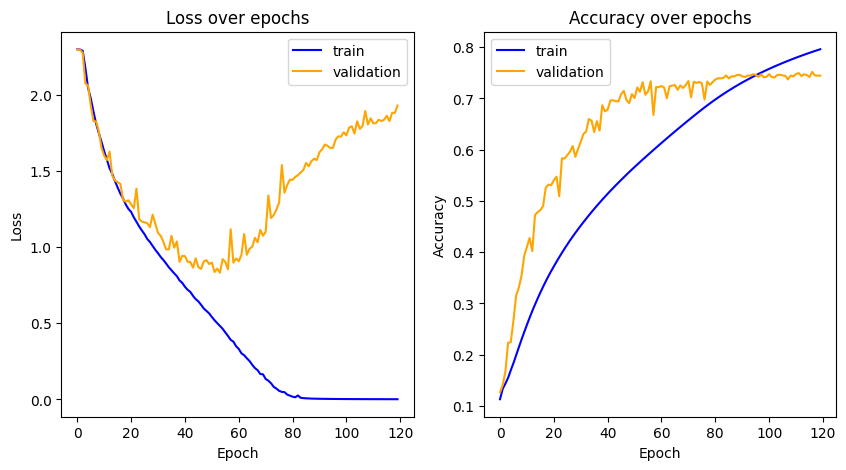

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
print(model)
train_loss = train_loss_epoch_history
print(train_loss_epoch_history)
# extract validation loss vector
valid_loss = valid_loss_history

# extract training acc vector
train_acc = train_acc_history

# extract validation acc vector
valid_acc = valid_acc_history

# create 1x2 subplots for loss on left, accuracy on right
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# plot train in blue, val in orange
axs[0].plot(train_loss, label='train', color='blue')
axs[0].plot(valid_loss, label='validation', color='orange')
axs[0].set_title('Loss over epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# plot train in blue, val in orange
axs[1].plot(train_acc, label='train', color='blue')
axs[1].plot(valid_acc, label='validation', color='orange')
axs[1].set_title('Accuracy over epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

# ENDS HERE